### Based off [this notebook](https://github.com/statmike/vertex-ai-mlops/blob/main/01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

In [1]:
# imports
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# auth
try:
    account = !gcloud config get-value account
    print(f"Authenticated as {account[0]}")
    project = !gcloud config get-value project
    PROJECT_ID = project[0]
    print(f"Logged into project {PROJECT_ID}")
except Exception as e:
    print(f"Not authenticated: {e}")
    print("Have you ran 'gcloud init'?")


Authenticated as esibleythrowaway@gmail.com
Logged into project totemic-guild-419402


In [3]:
# globals
REGION = 'us-central1'
EXPERIMENT = '01'
SERIES = '01'
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud'
BQ_SOURCE = 'bigquery-public-data.ml_datasets.ulb_fraud_detection'
BUCKET = PROJECT_ID
NOTEBOOK = 'eric-classifier'
DEPLOY_COMPUTE = 'n1-standard-4'
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id'
VAR_SPLITS = 'splits'
CLASSIFIER_VERSION = "0.0.1"

In [4]:
# clients
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project = PROJECT_ID)
gcs = storage.Client(project = PROJECT_ID)
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

## Data prep in GCS and BigQuery

In [16]:
# create bucket if not exists
if not gcs.lookup_bucket(BUCKET):
    bucketDef = gcs.bucket(BUCKET)
    bucket = gcs.create_bucket(bucketDef, project=PROJECT_ID, location=REGION)
    print(f'Created Bucket: {gcs.lookup_bucket(BUCKET).name}')
else:
    bucketDef = gcs.bucket(BUCKET)
    print(f'Bucket already exist: {bucketDef.name}')

# download the public dataset if not downloaded already
# it isn't important that we downloaded it from BQ; this was a public read-only location
file = f"{SERIES}/{EXPERIMENT}/data/{BQ_TABLE}.csv"
bucketDef = gcs.bucket(BUCKET)
if storage.Blob(bucket = bucketDef, name = file).exists(gcs):
    print(f'The file has already been created at: gs://{bucketDef.name}/{file}')
else:
    source = bigquery.TableReference.from_string(BQ_SOURCE)
    extract = bq.extract_table(source = source, destination_uris = [f'gs://{bucketDef.name}/{file}'])
    print('Creating the export ...')
    extract.result() 
    print(f'Exported the table to: gs://{bucketDef.name}/{file}')

# create our own BQ dataset to load our data into if not exists
datasets = list(bq.list_datasets())
dataset_ids = [ d.dataset_id for d in datasets ] 
if BQ_DATASET not in dataset_ids:
    ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
    ds.location = REGION
    ds.labels = {'experiment': f'{EXPERIMENT}'}
    ds = bq.create_dataset(dataset = ds)
    ds.created
    print(f"Dataset '{BQ_DATASET}' has been created")
else: 
    print(f"Dataset '{BQ_DATASET}' has already been created")

# create BQ table and load with our data if not exists
from google.cloud.exceptions import NotFound
try:
    table = bq.get_table(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')
    if table:
        print(f'The table already exists: {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')
except NotFound as error:
    print(f'Creating Table ...')
    destination = bigquery.TableReference.from_string(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")
    job_config = bigquery.LoadJobConfig(
        write_disposition = 'WRITE_TRUNCATE',
        source_format = bigquery.SourceFormat.CSV,
        autodetect = True,
        labels = {'experiment': f'{EXPERIMENT}'}
    )
    job = bq.load_table_from_uri(f"gs://{bucketDef.name}/{file}", destination, job_config = job_config)
    job.result()
    print(f'Finished creating table: {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}')

Bucket already exist: totemic-guild-419402
The file has already been created at: gs://totemic-guild-419402/01/01/data/fraud.csv
Dataset 'fraud' has already been created
The table already exists: totemic-guild-419402.fraud.fraud


In [9]:
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` TABLESAMPLE SYSTEM (1 PERCENT)
LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,8748,-1.070416,0.304517,2.777064,2.154061,0.254450,-0.448529,-0.398691,0.144672,1.070900,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,27074,1.165628,0.423671,0.887635,2.740163,-0.338578,-0.142846,-0.055628,-0.015325,-0.213621,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,28292,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,28488,1.070316,0.079499,1.471856,2.863786,-0.637887,0.858159,-0.687478,0.344146,0.459561,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,31392,-3.680953,-4.183581,2.642743,4.263802,4.643286,-0.225053,-3.733637,1.273037,0.015661,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


In [32]:
# prep data 
bq_tables = bq.list_tables(dataset=BQ_DATASET)
bq_tables = [ t.full_table_id.split('.')[-1] for t in bq_tables ] 
if f"{BQ_TABLE}_prepped" in bq_tables:
    print(f"The table already exists: '{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped'")
else: 
    query = f"""
    CREATE TABLE IF NOT EXISTS `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    WITH add_id AS(SELECT *, GENERATE_UUID() transaction_id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`)
    SELECT *,
        CASE 
            WHEN MOD(ABS(FARM_FINGERPRINT(transaction_id)),10) < 8 THEN "TRAIN" 
            WHEN MOD(ABS(FARM_FINGERPRINT(transaction_id)),10) < 9 THEN "VALIDATE"
            ELSE "TEST"
        END AS splits
    FROM add_id
    """
    job = bq.query(query = query)
    job.result()
    print(f" The job took {(job.ended-job.started).total_seconds()} seconds")

# sample data
query = f"""
SELECT splits, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY splits
"""
bq.query(query = query).to_dataframe()

The table already exists: 'totemic-guild-419402.fraud.fraud_prepped'


,splits,Count,Percentage
0,VALIDATE,28639,10.055581
1,TEST,28301,9.936905
2,TRAIN,227867,80.007514


## AutoML training

In [25]:
vertex_dataset_name = f'{SERIES}_{EXPERIMENT}_{NOTEBOOK}_{CLASSIFIER_VERSION}'
vertex_datasets = aiplatform.TabularDataset.list()
our_ds = [ ds for ds in vertex_datasets if ds.display_name == vertex_dataset_name ]
match our_ds:
    case []:
        dataset = aiplatform.TabularDataset.create(
            display_name = vertex_dataset_name, 
            bq_source = f'bq://{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped',
            labels = {'notebook':f'{NOTEBOOK}'}
        )

    case [single_item]:
        print(f"Vertex AI Dataset {vertex_dataset_name} has already been created. Did you want to increment the 'CLASSIFIER_VERSION' variable?")
        dataset = single_item
    
    case err:
        print(err)
        raise Exception()

Creating TabularDataset
Create TabularDataset backing LRO: projects/614098673135/locations/us-central1/datasets/8389921332279640064/operations/5205034204181561344
TabularDataset created. Resource name: projects/614098673135/locations/us-central1/datasets/8389921332279640064
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/614098673135/locations/us-central1/datasets/8389921332279640064')


In [32]:
MODEL_VERSION = "0.2"
MODEL_TYPE = "tabular_automl"
vertex_model_name = f"{vertex_dataset_name}_{MODEL_TYPE}_{MODEL_VERSION}" 
training_jobs = aiplatform.AutoMLTabularTrainingJob.list()
our_tj = [ tj for tj in training_jobs if tj.display_name == vertex_model_name ]
match our_tj:
    case []:
        column_specs = list(set(dataset.column_names) - set([VAR_TARGET, VAR_SPLITS, VAR_OMIT]))
        column_specs = dict.fromkeys(column_specs, 'auto')
        
        tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
            display_name = f'{vertex_model_name}',
            optimization_prediction_type = 'classification',
            optimization_objective = 'maximize-au-prc',
            column_specs = column_specs,
            labels = {'notebook':f'{NOTEBOOK}'}
        )
        
        model = tabular_classification_job.run(
            dataset = dataset,
            target_column = VAR_TARGET,
            predefined_split_column_name = VAR_SPLITS,
            budget_milli_node_hours = 1000,
            model_display_name = vertex_model_name,
            disable_early_stopping = False,
            model_labels = {'notebook':f'{NOTEBOOK}'}
        )

    case[single_item]:
        print(f"The training job already exists: '{single_item.display_name}'")
        model = [ m for m in aiplatform.Model.list() if m.display_name == vertex_model_name ][0]
        
    case err:
        print(err)
        raise Exception()


The training job already exists: '01_01_eric-classifier_0.0.1_tabular_automl_0.2'


## Deployment

In [30]:
endpoint_name = f"{vertex_model_name}_endpoint"
endpoints = aiplatform.Endpoint.list()
our_endpoint = [ e for e in endpoints if e.display_name == endpoint_name ]
match our_endpoint:
    case []:
        endpoint = aiplatform.Endpoint.create(
            display_name = endpoint_name,
            labels = {'notebook':f'{NOTEBOOK}'}
        )

        endpoint.deploy(
            model = model,
            deployed_model_display_name = NOTEBOOK,
            traffic_percentage = 100,
            machine_type = DEPLOY_COMPUTE,
            min_replica_count = 1,
            max_replica_count = 1
        )

    case [single_item]: 
        print(f"The training job already exists: '{single_item.display_name}'")
        endpoint = single_item 
        
    case err:
        print(err)
        raise Exception()

Creating Endpoint
Create Endpoint backing LRO: projects/614098673135/locations/us-central1/endpoints/6577443484100198400/operations/4466443865292800000
Endpoint created. Resource name: projects/614098673135/locations/us-central1/endpoints/6577443484100198400
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/614098673135/locations/us-central1/endpoints/6577443484100198400')


## Serving single prediction from BigQuery

In [43]:
test_data: pd.DataFrame = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()
cleaned_test_data = test_data[test_data.columns[~test_data.columns.isin([VAR_TARGET, VAR_OMIT, VAR_SPLITS])]]
test_answer = test_data[[VAR_TARGET]]
cleaned_test_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,115129,-0.608212,1.229362,2.437035,3.300745,0.581406,0.890973,0.744835,0.129881,-1.426577,...,-0.065234,0.080711,0.520134,-0.592601,0.068940,0.671852,0.348267,-0.123949,-0.172601,0.0
1,78061,1.151038,0.192985,1.093535,1.047658,-0.736774,-0.417745,-0.357777,0.067003,0.016424,...,-0.107653,0.008120,0.034498,0.070792,0.513268,0.277338,-0.542403,0.049143,0.028963,0.0
2,160475,-1.893675,1.061812,-0.565162,-0.881003,0.418310,-1.436985,0.189498,0.654700,-0.398496,...,-0.254071,-0.014849,-0.035409,-0.420567,0.125690,-0.136336,-0.151441,0.245346,-0.083213,0.0
3,152813,0.217852,1.728394,0.600695,4.408778,1.134174,0.158836,1.319731,-0.357460,-2.014953,...,0.297703,0.003698,0.504567,-0.201874,-0.069936,-0.543575,0.369814,0.296150,0.044454,0.0
4,134322,0.074208,0.646433,0.595510,0.907236,0.584523,0.103284,0.521797,0.158224,-1.070885,...,-0.226148,0.083198,0.250755,-0.123609,-0.311190,-0.649348,2.274925,-0.130737,-0.007134,0.0


In [36]:
data_for_pred_req = cleaned_test_data.to_dict(orient='records')[0]
data_for_pred_req['Time'] = str(data_for_pred_req['Time'])
instances = [json_format.ParseDict(data_for_pred_req, Value())]
parameters = json_format.ParseDict({}, Value())
prediction = endpoint.predict(instances=instances, parameters=parameters)
print(prediction)


Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.9993107914924622, 0.0006892087985761464]}], deployed_model_id='4409690339242147840', metadata=None, model_version_id='1', model_resource_name='projects/614098673135/locations/us-central1/models/2000408574622171136', explanations=None)

In [56]:
for pred in prediction.predictions: 
    max_index = pred['scores'].index(max(pred['scores']))
    predicted_class = pred['classes'][max_index]
    print(f"predicted_class: {predicted_class} == test_answer: {str(test_answer[VAR_TARGET][0])}")
    print(predicted_class == str(test_answer[VAR_TARGET][0]))

predicted_class: 0 == test_answer: 0
True


## Evaluation

In [58]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)
geteval.metrics['auPrc']

0.9997195

In [59]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28239.0, 2.0, 0.0]
True Label =  1  has Predicted labels =  [13.0, 47.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


In [60]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.9997857
Label =  1 has auPrc =  0.8708928


## Explanations 

In [62]:
explanation = endpoint.explain(instances=instances, parameters=parameters)
explanation.predictions

[{'classes': ['0', '1'],
  'scores': [0.9993107914924622, 0.0006892087985761464]}]

In [64]:
print("attribution:")
print("baseline output", explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output", explanation.explanations[0].attributions[0].instance_output_value)
print("output_index", explanation.explanations[0].attributions[0].output_index)
print("output display value", explanation.explanations[0].attributions[0].output_display_name)
print("approximation error", explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9999003410339355
instance output 0.9993107914924622
output_index [0]
output display value 0
approximation error 0.013253984741815284


/tmp/ipykernel_3033/424931546.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


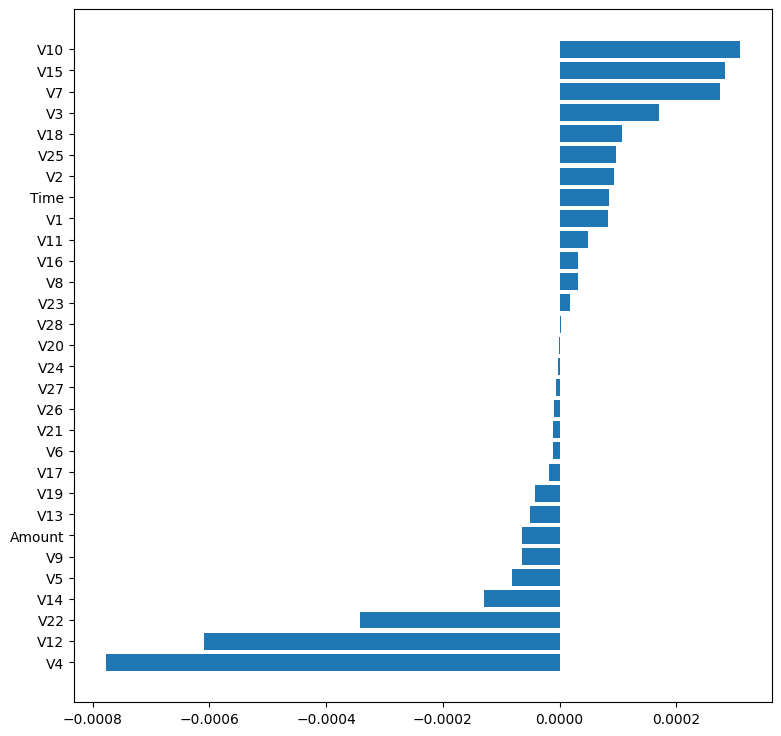

In [65]:
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

In [66]:
# Batch predict
# batch = aiplatform.BatchPredictionJob.create(
#     job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
#     model_name = model.name,
#     instances_format = "bigquery",
#     predictions_format = "bigquery",
#     bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
#     bigquery_destination_prefix = f"{PROJECT_ID}",
#     generate_explanation = True,
#     labels = {'notebook':f'{NOTEBOOK}'}
# )